# DL with PyTorch: Siamese Network: Persons Re-Identification:

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.5 MB/s eta 0:00:00
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-qrk2fxch
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-qrk2fxch
  Resolved https://github.com/albumentations-team/albumentations to commit 66212d77a44927a29d6a0e81621d3c27afbd929c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.24
    Uninstalling albucore-0.0.24:
      Successfully uninstalled albucore-0.0.24
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 2.0.8 requires albucore==0.0.24, but you have albucore 0.0.28 which is incompatible.

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [2]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (12942/12942), 27.68 MiB | 19.59 MiB/s, done.


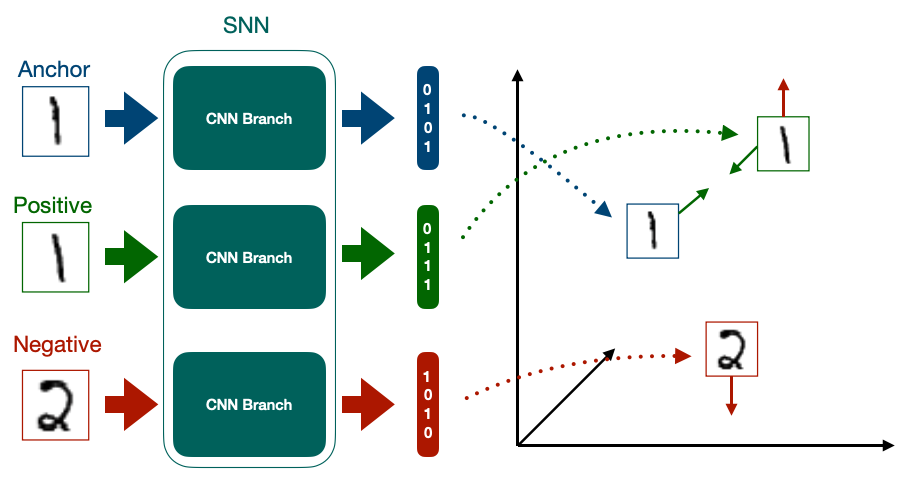

# Imports

In [1]:
import torch
import torchvision

print(f"PyTorch version: {torch.__version__}")
print(f"Is CUDA available? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")

else:
    print("CUDA is still not detected. Please check your NVIDIA Driver version using 'nvidia-smi'.")

PyTorch version: 2.2.2
Is CUDA available? True
GPU Device: NVIDIA GeForce MX330
CUDA Version: 12.1


In [3]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [5]:
DATA_DIR = '/content/Person-Re-Id-Dataset/train/'
CSV_FILE = '/content/Person-Re-Id-Dataset/train.csv'

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15

DEVICE = 'cuda'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head(5)

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [7]:
row = df.iloc[3950]

A_img = io.imread(DATA_DIR + row.Anchor)
N_img = io.imread(DATA_DIR + row.Negative)
P_img = io.imread(DATA_DIR + row.Positive)

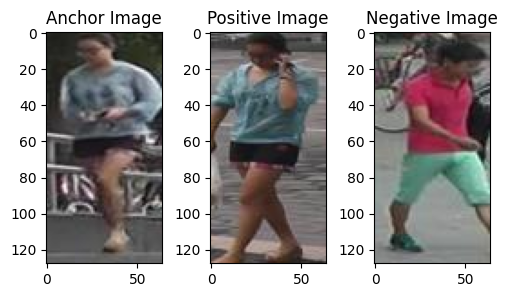

In [8]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (6, 3))
ax1.set_title('Anchor Image')
ax1.imshow(A_img)

ax2.set_title('Positive Image')
ax2.imshow(P_img)

ax3.set_title('Negative Image')
ax3.imshow(N_img)

In [9]:
train_df, valid_df = train_test_split(df, test_size= 0.20, random_state= 42)

print(train_df.shape, "\n\n", valid_df.shape)

(3200, 3) 

 (800, 3)


# Create APN Dataset

In [10]:
class APN_Dataset(Dataset):
  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    A_img = io.imread(DATA_DIR + row.Anchor)
    P_img = io.imread(DATA_DIR + row.Positive)
    N_img = io.imread(DATA_DIR + row.Negative)

    A_img = torch.from_numpy(A_img).permute(2, 0, 1) / 255.0
    P_img = torch.from_numpy(P_img).permute(2, 0, 1) / 255.0
    N_img = torch.from_numpy(N_img).permute(2, 0, 1) / 255.0

    return A_img, P_img, N_img

In [11]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f'Length of Train Set : {len(trainset)}\nLength of Test Set : {len(validset)}')

Length of Train Set : 3200
Length of Test Set : 800


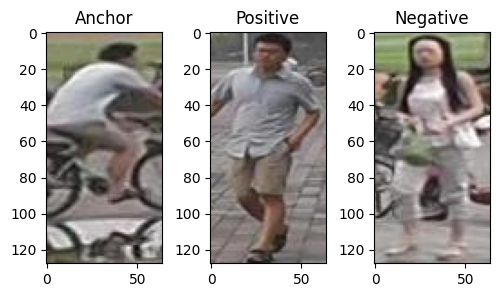

In [12]:
idx = -10
A, P, N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (6, 3))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1, 2, 0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1, 2, 0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1, 2, 0)), cmap = 'gray')

# Load Dataset into Batches

In [13]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle= True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [14]:
print(f"No. of batches in trainloader = {len(trainloader)}\nNo. of batches in validloader = {len(validloader)}")

No. of batches in trainloader = 100
No. of batches in validloader = 25


In [15]:
for A, P, N in trainloader:
  break;

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [16]:
class APN_Model(nn.Module):
  def __init__(self, emb_size = 512):
    super(APN_Model, self).__init__()

    self.efficientnet = timm.create_model('efficientnet_b0', pretrained= True)
    self.efficientnet.classifier = nn.Linear(in_features= self.efficientnet.classifier.in_features, out_features= emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [17]:
model = APN_Model()
model.to(DEVICE)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw):

# Create Train and Eval function

In [18]:
def train_fn(model, dataloader, optimizer, criterion):
  model.train()
  total_loss = 0.0

  for A, P, N in tqdm(dataloader):

    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [19]:
def eval_fn(model, dataloader, criterion):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for A, P, N in tqdm(dataloader):

      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)
      total_loss += loss.item()

    return total_loss / len(dataloader)

In [20]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= LR)

# Create Training Loop

In [21]:
best_valid_loss = np.inf

for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    best_valid_loss = valid_loss
    print('SAVED_WEIGHTS_SUCCESS')

  print(f'EPOCHS: {i+1}\nTrain_loss: {train_loss}\nValid_loss: {valid_loss}')

100%|██████████| 25/25 [00:02<00:00,  9.53it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 1
Train_loss: 0.6175308844447136
Valid_loss: 0.5280711448192597


100%|██████████| 25/25 [00:02<00:00,  9.53it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 2
Train_loss: 0.2824492013454437
Valid_loss: 0.4245209383964539


100%|██████████| 25/25 [00:02<00:00,  8.98it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 3
Train_loss: 0.15141242489218712
Valid_loss: 0.23854760706424713


100%|██████████| 25/25 [00:03<00:00,  7.84it/s]


EPOCHS: 4
Train_loss: 0.10876274988055229
Valid_loss: 0.2755261582136154


100%|██████████| 25/25 [00:02<00:00,  9.25it/s]


EPOCHS: 5
Train_loss: 0.07974677711725235
Valid_loss: 0.25711279690265654


100%|██████████| 25/25 [00:02<00:00,  9.65it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 6
Train_loss: 0.05977393209934235
Valid_loss: 0.22436650454998017


100%|██████████| 25/25 [00:02<00:00,  9.29it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 7
Train_loss: 0.07052368082106114
Valid_loss: 0.22205525994300843


100%|██████████| 25/25 [00:02<00:00,  9.78it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 8
Train_loss: 0.08272034242749214
Valid_loss: 0.19810229867696763


100%|██████████| 25/25 [00:02<00:00,  9.69it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 9
Train_loss: 0.04052601739764214
Valid_loss: 0.18452460825443268


100%|██████████| 25/25 [00:02<00:00,  9.85it/s]


EPOCHS: 10
Train_loss: 0.05059742294251919
Valid_loss: 0.1901577240228653


100%|██████████| 25/25 [00:02<00:00,  8.93it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 11
Train_loss: 0.04143987879157066
Valid_loss: 0.1792548781633377


100%|██████████| 25/25 [00:03<00:00,  7.85it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 12
Train_loss: 0.05081129863858223
Valid_loss: 0.17245795249938964


100%|██████████| 25/25 [00:02<00:00,  8.99it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 13
Train_loss: 0.05843845248222351
Valid_loss: 0.12557712376117705


100%|██████████| 25/25 [00:02<00:00,  9.88it/s]


EPOCHS: 14
Train_loss: 0.03272040143609047
Valid_loss: 0.13382346510887147


100%|██████████| 25/25 [00:02<00:00,  9.61it/s]

EPOCHS: 15
Train_loss: 0.035060030221939084
Valid_loss: 0.16643451273441315


# Get Anchor Embeddings

In [27]:
def get_encoding_csv(model, anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):

      A = io.imread(DATA_DIR + i)
      A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)

  return df_enc

In [28]:
model.load_state_dict(torch.load('best_model.pt'))

df_enc = get_encoding_csv(model, df['Anchor'])

100%|██████████| 4000/4000 [00:55<00:00, 72.32it/s] 


In [29]:
df_enc.to_csv('database.csv', index = False)
df_enc.head(5)

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,0.322128,0.448327,0.338386,-0.224677,0.996955,-0.144550,-0.059631,0.043334,0.810122,...,-0.704968,0.381793,0.300051,-0.372138,-0.243550,-0.067393,-0.285580,0.311567,-0.451642,0.235596
1,1420_c3s3_061978_03.jpg,-0.011817,0.591212,0.573841,-0.246208,0.767332,-0.075973,-0.139420,0.084485,1.159084,...,-0.205959,0.223009,0.424301,-0.088989,-0.206290,0.036609,-0.229990,0.383035,-0.328693,0.069314
2,1420_c5s3_062565_05.jpg,-0.016327,0.546865,0.405606,-0.115000,0.788710,-0.188894,-0.275498,-0.069809,1.058751,...,-0.243838,0.302286,0.431159,-0.065391,-0.129015,0.114954,-0.218639,0.545673,-0.500398,0.152865
3,1420_c6s3_085592_04.jpg,0.036530,-0.028733,0.473982,-0.104370,0.971362,-0.179479,-0.275610,0.400450,1.341397,...,-0.625760,0.905043,0.784477,-0.742007,-0.295543,-0.395382,-0.615904,0.450769,-0.625835,0.500755
4,0663_c5s3_085987_03.jpg,-0.388548,-0.000496,0.594352,-0.045875,-1.351389,0.197410,0.421953,0.197504,-0.564069,...,0.114698,-0.318472,-0.241598,-0.373840,0.127582,-0.360582,-0.192395,-0.057403,0.788156,0.031156


# Inference

In [30]:
def euclidean_dist(img_enc, anc_enc_arr):
  dist = np.sqrt(np.dot(img_enc - anc_enc_arr, (img_enc - anc_enc_arr).T))
  return dist

In [46]:
idx = 1500
img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1) / 255.0

model.eval()
with torch.no_grad():
  img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()

In [47]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()

anc_img_names = df_enc['Anchor']

In [48]:
distance = []

for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_dist(img_enc, anc_enc_arr[i: i+1, :])
  distance = np.append(distance, dist)

In [49]:
closest_idx = np.argsort(distance)

/usr/local/lib/python3.12/dist-packages/networkx/drawing/layout.py:987: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


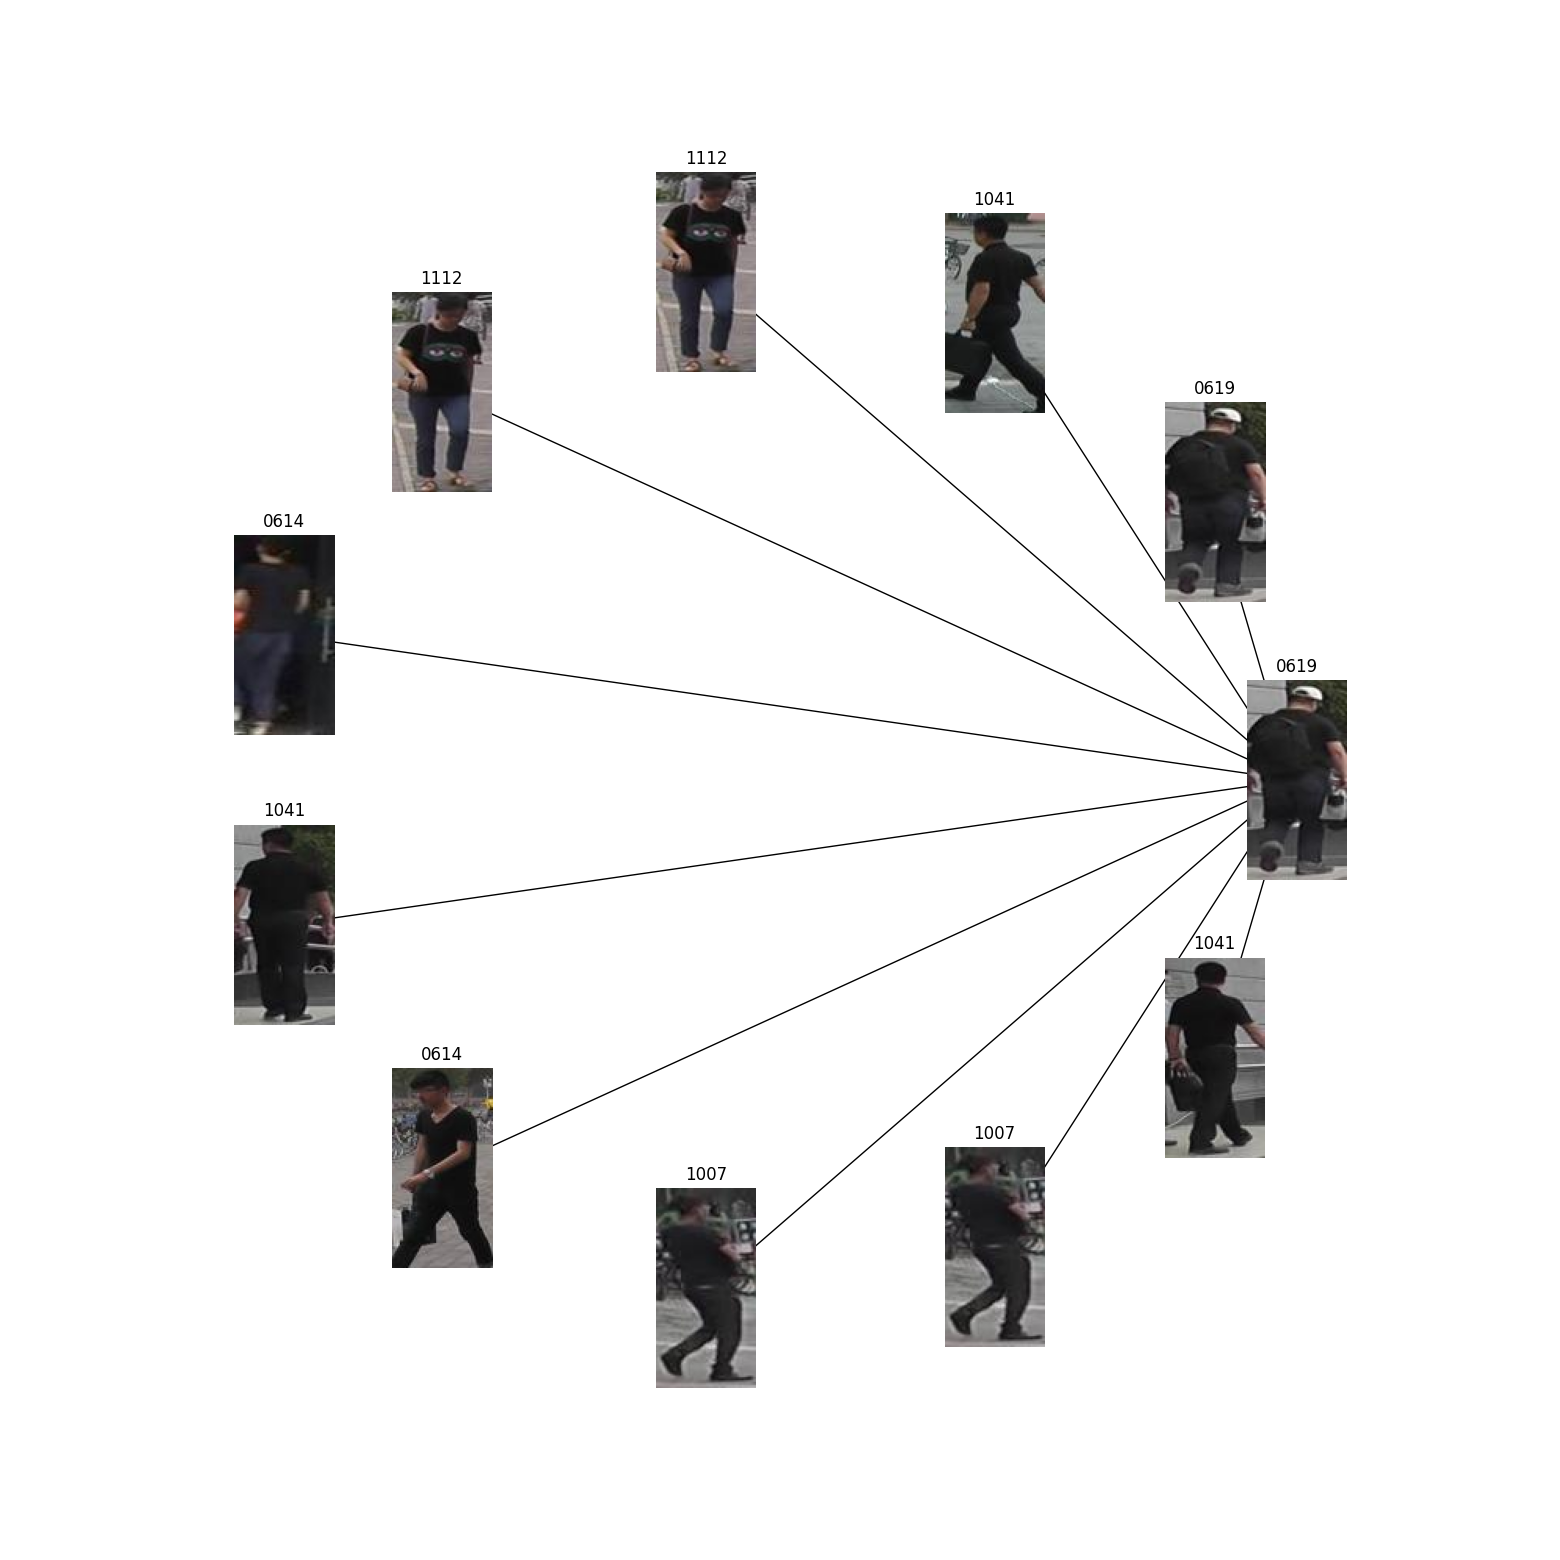

In [50]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 10);